# Sistemas Inteligentes

## Curso académico 2024-2025

### Práctica 1: Búsqueda en espacio de estados

#### Grupo 9

* Alberto Pérez Álvarez: alberto.perez25@alu.uclm.es
* Marcos López Gómez: marcos.lopez14@alu.uclm.es


## Estructura de datos
Hemos dividido las estructuras de datos en clases, una para cada entidad como se recomienda. Asi tenemos las clases de estructuras básicas Estado, Accion, Problema y Nodo. Además de las básicas, también tenemos las clases Problema, BusquedaNoInformada, BusquedaInformada, Anchura, Profundidad, PrimeroMejor y AEstrella, seguida de otra clase Heuristica para las heuristicas.

## 0.1 Importaciones
Imports necesarios para el código

In [1]:
#Clases básicas:
import json
from math import sqrt

#Clase búsqueda
from abc import ABC, ABCMeta,abstractmethod
import time

#Clase heurística
from math import sqrt

# Busqueda Informada
from heapq import heappush, heappop # Para la PriorityQueue

#Para el plot:
from pathlib import Path
from plot import plot

## 1. Clases básicas
Consideramos básicas las clases Estado, Accion, Problema y Nodo

### 1.1. Clase Estado

La clase Estado contiene los atributos necesarios para almacenar los datos referentes a la posición de un objeto, así como su identificador y algunos métodos para imprimir un objeto de la clase por pantalla, para comprobar si dos estados son iguales, para comprobar si el identificador se un objeto es menor que el de otro, y para comprobar si el identificador de un objeto es igual a uno introducido por pantalla.

In [2]:

class Estado:
    def __init__(self, id, latitude, longitude):
        self.identifier = id
        self.latitude = latitude
        self.longitude = longitude
    def __str__(self):
        return f"Interseccion: (id={self.identifier}, latitud={self.latitude}, longitud={self.longitude})"
    def __repr__(self):
        return f"{self.identifier}"
    def __eq__(self, otro):
        if not isinstance(otro, Estado):
            return False
        else:
            return self.identifier == otro.identifier
    def __lt__(self, otro):
        return self.identifier < otro.identifier
    def esId(self, id):
        return self.identifier == id

### 1.2. Clase Accion

La clase Acción contiene los atributos necesarios para almacenar tanto la posición inicial, como la final y el tiempo que se tarda en ir de la posición inicial a la final, así como algunos métodos para imprimir un objeto de la clase por pantalla, para comprobar si dos objetos son iguales, y un método para comprobar si un objeto es menor a otro, que usa el método del mismo nombre de la clase Estado.

In [3]:
class Accion:
    def __init__(self, origin, destination, distance, speed):
        self.origin = origin
        self.destination = destination
    # Dan la velocidad en Km/h y la distancia en m
        self.time = (distance/(speed*(10/36))) # Usamos: D->m. T->s y V->m/s
    def __str__(self):
        return f"Calle: Origen: {self.origin}, Destino: {self.destination})"
    def __repr__(self):
        return f"{self.origin} → {self.destination} ({self.time})"
    def __eq__(self, otro):
        if not isinstance(otro, Accion):
            return False
        else:
            return self.origin == otro.origin and self.destination == otro.destination and self.time == otro.time
    def __lt__(self, otro):
        return self.destination < otro.destination

### 1.3. Clase Problema

La clase Problema carga la información de un archivo json, el cual contiene los datos sobre el caso para el que se tiene que encontrar la solución. Esto lo hace mediante su método init, y esos datos los almacena en sus atributos, entre los que se encuentran un diccionario de estados y otro de acciones, la velocidad máxima de entre todos los segmentos, así como el estado inicial y final del problema. La clase Problema también tiene un método para obtener un objeto a partir de su ID, otro para obtener el destino de una acción y otro para obtener todas las accioners de un estado partiea partir de su ID.

In [4]:
class Problema:   
    #Constructor de Problema
    def __init__(self,ruta):
        with open(ruta, 'r') as file:
            self.data = json.load(file)
        
        self.dic_estados = {}
        self.dic_acciones = {}
        self.maxSpeed = 0

        # Pasamos las intersecciones del JSON a un nuevo diccionario estados
        for inter in self.data['intersections']:
            self.dic_estados.update({inter['identifier']:(Estado(inter['identifier'], inter['latitude'], inter['longitude']))})         
            self.dic_acciones.update({inter['identifier']:[]})  # Acciones = {id:PriorityQueue de Acciones}
            
        # Cargamos los nodos iniciales y finales del JSON.
        self.Inicial = self.dic_estados[self.data["initial"]]
        self.Final = self.dic_estados[self.data["final"]]
        
        # Pasamos los segmentos del JSON a un nuevo diccionario acciones     
        for seg in self.data['segments']:
            if (seg['speed']*(10/36) > self.maxSpeed):
                self.maxSpeed = seg['speed']*(10/36) # km/h -> m/s
            accion=Accion(seg['origin'], seg['destination'], seg['distance'], seg['speed'])
            heappush(self.dic_acciones[seg['origin']], accion)  # Metemos las acciones de cada Estado en una PriorityQueue

    # Obtener un objeto Estado a partir de su ID
    def getEstado(self, id):
        return self.dic_estados[id]

    # Obtener el destino de una Accion
    def getDestinoDe(self,accion):
        return self.dic_estados[accion.destination]

    # Obtener todas las acciones de un estado a partir de su ID
    def getAccionesDe(self,id):
        return self.dic_acciones[id]

### 1.4. Clase Nodo

La clase nodo tiene como atributos la intersección en la que se encuentra, el nodo padre, la última acción tomada y por la que estamos en esta intersección, el coste acumulado ewn este nodo, la profundidad del nodo, y el número de nodos a los que se han generado hasta el momento; también contiene algunos métodos para imprimir por pantalla, ver si dos nodos son iguales y comprobar si un nodo es menor que otro.

In [5]:
class Nodo:
    def __init__(self, interseccion, padre = None, accionTomada = None, coste = 0, profundidad = 0, nGenerado = 0):
        self.estado = interseccion
        self.padre = padre
        self.accion = accionTomada
        self.coste = coste
        self.profundidad = profundidad
        self.nGenerado = nGenerado  # El 1º generado deberia empezar en 1 no en 0, pues dijo en clase que   
                                    # se deberia contar pero ellos no lo cuentan en sus soluciones, asi que 
                                    # nosotros tampoco
    def __str__(self):
        return f"Nodo(estado={self.estado}, padre={self.padre}, accion={self.accion}, coste={self.coste}, profundidad={self.profundidad})"
    def __repr__(self):
        return f"{self.estado.identifier}"
    def __eq__(self,otro):
        if not isinstance(otro, Nodo):
            return False
        return self.estado.__eq__(otro.estado) and self.nGenerado.__eq__(otro.nGenerado)
    def __lt__(self,otro):
        return self.estado.__lt__(otro.estado)

## 2. Clase Busqueda

Contiene toda la lógica principal de los algoritmos de busqueda. Es la parte del código común a todos los algoritmos, por lo que es abstracta y faltan por implementar los métodos AñadirNodoAFrontera y ExtraerNodoAFrontera. Estos métodos los implementarán las clases de los tipos de algoritmos pertinentes, que heredarán de esta clase. La clase Búsqueda tiene como atributos a "frontera" la cual se utilizará como una heapq, ya que es más rápido que con una PriorityQueue al no prevenir errores de hilos y ya que no se usa concurrencia en esta práctica nos ha parecido mejor opción, "problema" que contiene el problema en cuestión, "tInicio" y "tFinal" que contienen el tiempo en el inicial y final de la ejecución respectivamente, "cerrados" que es una lista que contiene nodos ya visitados y "nodo" que contiene el nodo actual, y el resto de atributos son para obtener estadísticas al final de la ejecución.

La clase Busqueda también tiene otros métodos, como "busqueda" que busca nodos en "frontera" hasta que esta esté vacía, lo que comprueba mediante el método "esVacia" y comprueba si son solución con el método "testObjetivo", y si alguno es solución, imprime las acciones que se han llevado a cabo hasta llegar a ese nodo, y devulve la lista de todos los estados por los que se han pasado; si no es solución se comprueba si el nodo no está en "cerrados", si no está entonces llama a la función "expandir", que obtiene los sucesores de ese nodo llamando a "añadirNodosAFrontera" que es un método distinto en cada algoritmo. El resto de métodos son para imprimir las estadísticas.

In [6]:
class Busqueda(ABC):
    def __init__(self, problema):
        self.frontera = []  # Declaración igual en todos los algoritmos
                            # heapq usa una lista como priority vacia.
                            # heapq es algo mas rapido que PriorityQueue al 
                            # no prevenir errores de hilos. Como no usamos concurrencia 
                            # de hilos en esta práctica, heapq es ideal
                            # https://docs.python.org/3/library/heapq.html
                            # https://docs.python.org/3/library/queue.html#queue.PriorityQueue
        self.problema = problema
        self.tInicio = 0
        self.tFinal = 0
        self.cerrados = set()        # Para no volver a expandir nodos ya visitados
        self.nodo = Nodo(problema.Inicial)
        # Estadisticas:
        self.nExpandidos = 0
        self.nProfundidad = 0
        self.nCosteTotal = 0           
        self.nGenerados = 0

    def expandir(self,nodo,problema):
        acciones = problema.getAccionesDe(nodo.estado.identifier)
        while acciones:
            accion = heappop(acciones)
            sucesor = Nodo(problema.getEstado(accion.destination))
            sucesor.padre = nodo
            sucesor.accion = accion
            sucesor.coste = nodo.coste + accion.time
            sucesor.profundidad = nodo.profundidad + 1
            self.nGenerados = self.nGenerados + 1
            sucesor.nGenerado = self.nGenerados
            self.añadirNodoAFrontera(sucesor, self.frontera)    # Añadimos los sucesores a frontera.
                                                                # Nos ahorramos un bucle For al añadirlos 
                                                                # desde expandir
                                                            
    def busqueda(self):
        self.tInicio = time.time()
        self.añadirNodoAFrontera(self.nodo,self.frontera)
        while(not self.esVacia(self.frontera)):
            self.nodo = self.extraerNodoDeFrontera(self.frontera)
            if (self.testObjetivo(self.nodo)):
                self.tFinal = time.time()
                return self.listaAcciones(self.nodo)
            if (not self.nodo.estado.identifier in self.cerrados):
                self.expandir(self.nodo, self.problema)     # Obtenemos los sucesores con Expandir()
                self.nExpandidos = self.nExpandidos + 1
                self.cerrados.add(self.nodo.estado.identifier)
        self.tFinal = time.time()
        return self.imprimirResultado([])

    def testObjetivo(self,nodo):
        return nodo.estado.__eq__(self.problema.Final)

    def listaAcciones(self,nodo):
        sol = []                         # Lista de acciones que han llevado desde el final al inicial
        estados = []                     # Lista de ids de los estados desde el final al inicial
        self.nCosteTotal = nodo.coste    # nodo.coste es acumulativo
        self.nProfundidad=nodo.profundidad
        while (nodo.padre):
            sol.append(nodo.accion)
            estados.append(nodo.estado.identifier)
            nodo = nodo.padre
        estados.append(nodo.estado.identifier) # Añadimos el inicial
        sol.reverse()                   # Ahora es una lista de acciones desde el inicial al final
        self.imprimirResultado(sol)
        estados.reverse()
        return estados

    def imprimirResultado(self,sol):
        if not sol : print("Solución no encontrada")
        print("Nodos generados:",self.nGenerados)
        print("Nodos expandidos:",self.nExpandidos)
        print("Tiempo de ejecución:",(self.formatearTiempo(self.tFinal - self.tInicio)),"segundos")
        print("Profundidad:",self.nProfundidad)
        print("Coste de la solución:",self.formatearTiempo(self.nCosteTotal))
        print("Solución:",sol)
    
    def formatearTiempo(self, tiempo):  # Para imprimir los tiempos como en las soluciones
        horas = int(tiempo // 3600)
        minutos = int((tiempo % 3600) // 60)
        segundos = int(tiempo % 60)
        milisegundos = int((tiempo - int(tiempo)) * 1000000)
        return f"{horas:01d}:{minutos:02d}:{segundos:02d}.{milisegundos:06d}"

    def esVacia(self, frontera): # Igual en todos los algoritmos
        return len(frontera) == 0

    @abstractmethod
    def añadirNodoAFrontera(self, nodo, frontera):
        pass
    @abstractmethod
    def extraerNodoDeFrontera(self, frontera):
        pass


## 3. Algoritmos de búsqueda no informada
Para este tipo de algoritmos tenemos una clase abstracta que hereda de Búsqueda e implementa los métodos y estructuras comunes a los dos tipos de algoritmos que tenemos de búsqueda no informada (anchura y profundidad en grafos). La clase BusquedaNoInformada tiene un método no abstracto, que es "añadirNodoAFrontera", que es es el mismo para busqueda en anchura y en profundidad, que lo que hace es añadir un nodo a la frontera, y tambien tiene un método abstracto que es "extraerNodoDeFrontera", es abstracto ya que debe ser diferente en busqueda en anchura y en profundidad.

In [7]:
class BusquedaNoInformada(Busqueda,metaclass=ABCMeta):
    def __init__(self, problema):
        super().__init__(problema)
        # Frontera se usará como lista de nodos a ser expandidos

    def añadirNodoAFrontera(self, nodo, frontera):  # Es igual en Anchura y Profundidad
        frontera.append(nodo)

    @abstractmethod
    def extraerNodoDeFrontera(self, frontera):
        pass

### 3.1 Algoritmo de anchura en grafos


La clase Anchura solo tiene el método "extraerNodoDeFrontera", ya que el resto de métodos los hereda de su clase padre. Lo que hace este método es coger el primer elemento de "frontera".

In [8]:
class Anchura(BusquedaNoInformada):
    def extraerNodoDeFrontera(self, frontera):
        return frontera.pop(0)

### 3.2 Algoritmo de profundidad en grafos

La clase Profundidad solo tiene el método "extraerNodoDeFrontera", ya que al igual que la clase Anchura, los demas métodos los hera de su clase padre. En este caso lo que hace el método es coger el último elemento disponible en "frontera".

In [9]:
class Profundidad(BusquedaNoInformada):
    def extraerNodoDeFrontera(self, frontera):
        return frontera.pop()

## 4. Algoritmos de búsqueda informada

Para los algoritmos de búsqueda informada tenemos al igual que para los anteriores, una clase abstracta que implementa los métodos y estructuras comunes a los dos tipos de algoritmo de búsqueda informada. En este caso además tenemos una clase abstracta más relacionada, llamada Heurística, de la cual también hereda esta clase. En este caso el método abstracto es "añadirNodoAFrontera", ya que este método debe ser diferente en los algoritmos Primero mejor y A*. Sin embargo el método "extraerNodoDeFrontera" es el mismo para ambos algoritmos, y lo que hace es simplemente sacar el primer elemento de la frontera.

In [10]:
class BusquedaInformada(Busqueda,metaclass=ABCMeta):
    def __init__(self, problema,heuristica):
        super().__init__(problema)
        # Frontera se usará como PriorityQueue de nodos a ser expandidos
        self.H = heuristica
    @abstractmethod
    def añadirNodoAFrontera(self, nodo, frontera):
        pass

    def extraerNodoDeFrontera(self, frontera):  # Igual en PrimeroMejor y AEstrella
        return heappop(frontera)[1]             # Sacamos el nodo que toca

### 4.1. Primero mejor

Al igual que pasaba con las clases de los algoritmos de búsqueda no informada, esta clase solo tiene un método, ya que el resto los hereda de su clase padre. En este caso el método "añadirNodoAFrontera" lo que hace es añadir el nodo a "frontera", pero como una tupla con la heurística, para que como "frontera" es una PriorityQueue, ordene los nodos según esta última.

In [11]:
class PrimeroMejor(BusquedaInformada):
    def añadirNodoAFrontera(self, nodo, frontera):                                                                                                                                                                                                                                 # Una tripla con su heuristica, orden de generación y el propio nodo
        heappush(frontera,(self.H.heuristica(nodo),nodo))   # Si la heuristica es igual se elige el de menor id                                                                            

### 4.2. A*

La clase AEstrella tiene solo el método "añadirNodoAFrontera" ya que el resto los herada de su clase padre. Lo que hace este método es añadir una tupla a "frontera" compuesta de, primero la suma del coste acumulado del nodo y de la heuristica de ese nodo, para que la PriorityQueue se ordene con respecto a este valor y segundo el nodo en si.

In [12]:
class AEstrella(BusquedaInformada):
    def añadirNodoAFrontera(self, nodo, frontera):
        gn = nodo.coste   
        hn = self.H.heuristica(nodo)
        fn = hn + gn                                                        
        heappush(frontera, (fn,  nodo))

### 4.3. Heuristica
Para la heurística tenemos una clase dedicada abstracta que implementa los métodos comunes a ambas heurísticas y otras dos clases que implementan una de las tres heurísticas en concreto, heredando de la clase abstracta. Lo que cambia entre estas es simplemente la manera de calcular la distancia, entre calcularla en línea recta usando pitágoras (heurística euclidiana), usar la distancia geodésica o calcularla con la distancia de Manhattan.

In [13]:
class Heuristica(ABC):
    def __init__(self,problema):
        self.problema = problema
    
    @abstractmethod
    def distancia(self,estado,final):
        pass

    # Devuelve el tiempo estimado (coste) desde un estado hasta el estado final
    def tiempo(self, distancia):
        return distancia/self.problema.maxSpeed # D->m V->m/s T->s
    
    # Metodo al que llamamos para calcular la heurística.
    def heuristica(self, nodo):
        return self.tiempo(self.distancia(nodo.estado,self.problema.Final))
    
# Dos maneras de hacer heuristicas calculando distancias
class Heuristica1(Heuristica):
    # Euclidea. Pitagoras. (Línea recta)
    def distancia(self, estado, final):
        return sqrt((estado.latitude - final.latitude)**2 + (estado.longitude - final.longitude)**2)*100000
    
class Heuristica2(Heuristica):
    # Geodesica. (Línea recta + curvatura de la Tierra)
    def distancia(self, estado, final):
        return geodesic((estado.latitude,estado.longitude), (final.latitude,final.longitude)).meters # La usan en las soluciones. Mas exacta al ser la tierra una elipse
    # https://pypi.org/project/geopy/
    # https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://geopy.readthedocs.io/&ved=2ahUKEwiWq97Su7OJAxUt_7sIHanJI7kQFnoECBYQAQ&usg=AOvVaw01VCwbF-UadfgLzmTCV4Mo

class Heuristica3(Heuristica):
    # Distancia de Manhattan. Diferencia en latitudes y longitudes.
    def distancia(self,estado,final):
        return abs(estado.latitude - final.latitude) + abs(estado.longitude - final.longitude)*100000

#### 4.3.1 Comparación de heurísticas
Entre las tres heurísticas, la que más se aproxima a los resultados dados en clase y la más exacta es la Heuristica2, que usa la distancia geodésica usando cálculos complejos que proporciona el paquete geopy. Para las otras dos heurísticas, al hacer los cálculos con coordenadas tuvimos problemas al pasarlas a metros, ya que dependiendo del lugar la equivalencia puede ir desde 1 hasta 111.000 metros por unidad de longitud-latitud.  Haciendo comparaciones al descubrir la geodesica vimos que al multiplicarlas por 100000 obteniamos un resultado de la misma magnitud que con la geodésica.

## 5. Inicialización de las clases y determinación de la ruta


In [14]:
#Borrar todas estas rutas
Huge2 = 'problems/huge/calle_herreros_albacete_2000_2.json' 
Large1 = 'problems/large/calle_agustina_aroca_albacete_1000_2.json' 
Large2 = 'problems/large/calle_f_albacete_5000_4.json'
Large3 = 'problems/large/calle_cardenal_tabera_y_araoz_albacete_1000_3.json'
Large4 = 'problems/large/calle_ínsula_barataria_albacete_1000_1.json' 
Huge1 = 'problems/huge/calle_del_virrey_morcillo_albacete_2000_4.json'
Test1 = 'problems/test/test.json'
Test2 = 'problems/test/test2.json'
Medium1 = 'problems/medium/calle_del_virrey_morcillo_albacete_2000_4.json'
Small1 = 'problems/small/calle_del_virrey_morcillo_albacete_250_3.json'
Small2 = 'problems/small/calle_franciscanos_albacete_250_0.json' # Sin solucion
Small3 = 'problems/small/calle_palmas_de_gran_canaria_albacete_250_4.json' 

RUTAJSON = Small3
#Ruta del JSON a cambiar:
#RUTAJSON = 'problems/huge/calle_del_virrey_morcillo_albacete_2000_4.json'

## 5.1 Anchura
Algoritmo de anchura


Anchura:
Nodos generados: 91
Nodos expandidos: 48
Tiempo de ejecución: 0:00:00.000110 segundos
Profundidad: 8
Coste de la solución: 0:00:52.022520
Solución: [1526705367 → 1736073022 (7.000679999999999), 1736073022 → 1526705389 (6.8414399999999995), 1526705389 → 1529623348 (6.3098399999999994), 1529623348 → 1322977383 (4.53768), 1322977383 → 1529201976 (7.200239999999999), 1529201976 → 1526705382 (6.30216), 1526705382 → 1526705395 (10.02624), 1526705395 → 1528823322 (3.80424)]


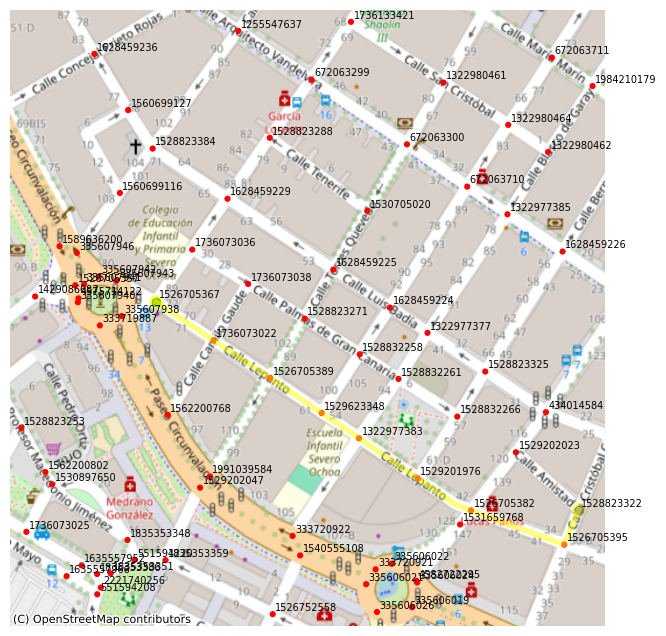

In [15]:
print("\nAnchura:")
solucion = Anchura(Problema(RUTAJSON)).busqueda()
plot(RUTAJSON,solucion)